In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from datetime import datetime
import tf2onnx
import onnx
import onnxruntime as ort
import os
import boto3

2024-03-09 10:55:47.126867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 10:55:47.742390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 10:55:47.743094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 10:55:49.426383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(X_train,y_train),(X_test,y_test) = keras.datasets.mnist.load_data()

X_train = X_train/255
X_test = X_test/255

# Training

Let's train a simple neural network:

In [3]:
model = Sequential()

model.add(Flatten(input_shape=(28,28)))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 104938 (409.91 KB)
Trainable params: 104938 (409.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
history = model.fit(X_train,y_train,epochs=10,validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2958 - accuracy: 0.9135 - val_loss: 0.1580 - val_accuracy: 0.9531
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1259 - accuracy: 0.9626 - val_loss: 0.1244 - val_accuracy: 0.9620
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0839 - accuracy: 0.9736 - val_loss: 0.1078 - val_accuracy: 0.9674
Epoch 4/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9807 - val_loss: 0.0896 - val_accuracy: 0.9746
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0492 - accuracy: 0.9846 - val_loss: 0.0976 - val_accuracy: 0.9720
Epoch 6/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0385 - accuracy: 0.9877 - val_loss: 0.1017 - val_accuracy: 0.9722
Epoch 7/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.1016 - val_accuracy:

In [5]:
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=1)
accuracy_score(y_test,y_pred)

313/313 [==============================] - 0s 571us/step


0.9767

# Demo

Let's try out the nn with a small demo, given the following:

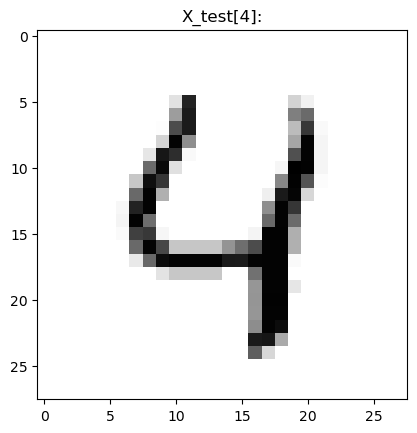

In [6]:
plt.imshow(X_test[4], cmap="Greys")
plt.title('X_test[4]:')
plt.show()

the model predicts it is:

In [7]:
prediction = model.predict(X_test[4].reshape(1,28,28)).argmax(axis=1)[0]
print('prediction: ', prediction)

1/1 [==============================] - 0s 15ms/step
prediction:  4


# Model Save

In [8]:
input_signature = [tf.TensorSpec([1, 28, 28], tf.double, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=12)
onnx.save(onnx_model, "model1.onnx")

2024-03-09 10:56:19.883846: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-03-09 10:56:19.883998: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-03-09 10:56:20.080320: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-03-09 10:56:20.080517: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


# Demo using onnx file

In [9]:
model_onnx = onnx.load('model1.onnx')
output = [node.name for node in model_onnx.graph.output]
print(output)

sess = ort.InferenceSession("model1.onnx")
results_ort = sess.run(['dense_2'], {'x': X_test[4].reshape(1,28,28)})
prediction = results_ort[0].argmax(axis=1)[0]
print('prediction: ', prediction)

['dense_2']
prediction:  4


# Store onnx on bucket

In [11]:
registeredmodel_name = "mnist"
version_name = "v1.nb"+datetime.now().strftime("%Y%m%d%H%M%S")
print(f"Will be using: {registeredmodel_name}:{version_name} in the remainder of this task")

s3 = boto3.resource(
    service_name='s3',
    region_name='default',
    aws_access_key_id=os.environ['accesskey'],
    aws_secret_access_key=os.environ['secretkey'],
    use_ssl=False,
    endpoint_url='http://minio-service.kubeflow.svc.cluster.local:9000',
    verify=False
)

bucket_name = 'mybucket'
odh_secret_name = f'aws-connection-{bucket_name}'
in_bucket_path = version_name
in_bucket_target = f'{in_bucket_path}/mnist.onnx'
full_bucket_target = f's3://{bucket_name}/{in_bucket_target}'

my_bucket = s3.Bucket(bucket_name)
my_bucket.upload_file("model1.onnx", in_bucket_target)

print("ls:")
for obj in my_bucket.objects.filter():
    print(obj.key)

Will be using: mnist:v1.nb20240309105815 in the remainder of this task
ls:
README.md
v1.nb20240309105815/mnist.onnx


# Register model on Model Registry

In [13]:
from model_registry import ModelRegistry

registry = ModelRegistry(server_address="model-registry-service.kubeflow.svc.cluster.local", port=9090, author="author")

rm = registry.register_model(registeredmodel_name,
                                full_bucket_target,
                                model_format_name="onnx",
                                model_format_version="1",
                                storage_key=odh_secret_name,
                                storage_path=in_bucket_path,
                                version=version_name,
                                description="demo20231121 e2e MNIST",
                                )
print("RegisteredModel:")
print(registry.get_registered_model(registeredmodel_name))
print("ModelVersion:")
print(registry.get_model_version(registeredmodel_name, version_name))
print("ModelArtifact:")
print(registry.get_model_artifact(registeredmodel_name, version_name))

RegisteredModel:
RegisteredModel(id='1', description='', external_id='', create_time_since_epoch=1709982167800, last_update_time_since_epoch=1709982167800, state=<ContextState.LIVE: 'LIVE'>, name='mnist')
ModelVersion:
ModelVersion(name='v1.nb20240309105815', id='2', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1709982167890, last_update_time_since_epoch=1709982167890, state=<ContextState.LIVE: 'LIVE'>, model_name='mnist', version='v1.nb20240309105815', author='author', metadata={}, artifacts=NOTHING, _registered_model_id=NOTHING)
ModelArtifact:
ModelArtifact(id='1', description='', external_id='', create_time_since_epoch=1709982168023, last_update_time_since_epoch=1709982168023, name='mnist', uri='s3://mybucket/v1.nb20240309105815/mnist.onnx', state=<ArtifactState.UNKNOWN: 0>, model_format_name='onnx', model_format_version='1', storage_key='aws-connection-mybucket', storage_path='v1.nb20240309105815', service_account_name='', _model_version_id=NOTHING)